---
# **Masking Detectors**
---

Within this notebook, we analyze the effects on the background fit of removing detectors in full blocks (1/16th of the detector plane) or in DMs (1/8th of a block). We will import the background fit from .csv and create our background model dpis. We will then compare the dpis from the data and model for the same time window where the best fit occurs.

In [1]:
import numpy as np
from astropy.io import fits # FITS -> Flexible Image Transport System.
from astropy.table import Table, vstack # astropy.table provides functionality
                                        # for storing and manipulating 
                                        # tables of data familiar to numpy users.
                                        # Table is the generic object for 
                                        # creating tables and vstack is a function
                                        # for stacking multiple tables vertically 
                                        # along rows.
from astropy.wcs import WCS # WCS -> World Coordinate System. The library 
                            # contains utilities for managing WCS 
                            # transformations defined in FITS WCS standard 
                            # conventions.
import os
import argparse
import logging, traceback   # logging odule defines functions and classes which
                            # implement a flexible even logging system for 
                            # applications and libraries. traceback provides 
                            # inverface to extract, format and print stack
                            # traces of python programs.
import pandas as pd
from copy import copy, deepcopy # for compound objects (objects that contain 
                            # other objects) a shallow copy constructs a new 
                            # compound object and then inserts references into
                            # it to the objects found in the original. The 
                            # function copy performs a shallow copy. deepcopy
                            # performs a deep copy which constructs a new 
                            # compound object and then, recursively, inserts 
                            # copies into it of the objects found in the original.
import multiprocessing as mp # This library allows the programmer to fully
                             # leverage multiple processors on a given machine.
import matplotlib.pyplot as plt
from nitrates.analysis_seeds.bkg_rate_estimation import get_avg_lin_cub_rate_quad_obs
from nitrates.config import quad_dicts, EBINS0, EBINS1,\
                solid_angle_dpi_fname, bright_source_table_fname
from nitrates.lib.sqlite_funcs import write_rate_fits_from_obj, get_conn
from nitrates.lib.dbread_funcs import get_info_tab, guess_dbfname, get_files_tab
from nitrates.lib.event2dpi_funcs import filter_evdata
from nitrates.models.models import Bkg_Model_wFlatA, CompoundModel, Point_Source_Model_Binned_Rates
from nitrates.llh_analysis.LLH import LLH_webins
from nitrates.llh_analysis.minimizers import NLLH_ScipyMinimize, NLLH_ScipyMinimize_Wjacob
from nitrates.response.ray_trace_funcs import RayTraces
from nitrates.lib.coord_conv_funcs import convert_radec2imxy
from nitrates.lib.gti_funcs import add_bti2gti, bti2gti, gti2bti, union_gtis
from nitrates.lib.wcs_funcs import world2val
import nitrates

Could not get the $HEADAS system variable. Please ensure that this is set and points to the HEASOFT directory.
Could not get the $CALDB system variable. Please ensure that this is set and points to the CALDB directory.
No module named 'ROOT'
Please install the Python ROOT package to be able to run the full forward modeling calculations.
16
16
[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]), array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]), array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]), array([73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]), array([ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104]), array([109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122]), array([127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140]), array([145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,

In [2]:
# Change directory to the same directory as do_bkg_estimation_wPSs_mp2.py
os.getcwd()
os.chdir('/Volumes/WD/Development/Programming/NITRATES_RESP_DIR_PIP/')
print(os.getcwd())

/Volumes/WD/Development/Programming/NITRATES_RESP_DIR_PIP


In [3]:
NITRATES_path=nitrates.config.NITRATES_RESP_DIR
work_dir = os.path.join(NITRATES_path, 'F646018360')
conn = get_conn(os.path.join(work_dir,'results.db'))
info_tab = get_info_tab(conn)
files_tab = get_files_tab(conn)

trigtime = info_tab['trigtimeMET'][0]
evfname = os.path.join(work_dir,'filter_evdata.fits')
ev_data = fits.open(evfname)[1].data
solid_angle_dpi = np.load(solid_angle_dpi_fname)

attfile = fits.open(os.path.join(work_dir,'attitude.fits'))[1].data
dmask = fits.open(os.path.join(work_dir,'detmask.fits'))[0].data
bl_dmask = (dmask==0.)
ndets = np.sum(dmask==0)

ebins0 = np.array([15.0, 24.0, 35.0, 48.0, 64.0])
ebins0 = np.append(ebins0, np.logspace(np.log10(84.0), np.log10(500.0), 5+1))[:-1]
ebins0 = np.round(ebins0, decimals=1)[:-1]
ebins1 = np.append(ebins0[1:], [350.0])
ebins = [ebins0, ebins1]
nebins = len(ebins0)

try:
    GTI = Table.read(evfname, hdu='GTI_POINTING')
    print("Found GTI_POINTING events")
except:
    GTI = Table.read(evfname, hdu='GTI')
    print("Did not find GTI_POINTING events")

gti_bl = (GTI['STOP']>(trigtime-2e3))&(GTI['START']<(trigtime+2e3))

tot_exp = 0.0
for row in GTI:
    tot_exp += (row['STOP'] - row['START'])

tmin = GTI['START'][0]
tmax = GTI['STOP'][-1]
tmids = (GTI['START']+GTI['STOP'])/2.
tmid = tmids[np.argmin(np.abs(tmids - trigtime))]

rt_dir = os.path.join(NITRATES_path,'ray_traces_detapp_npy')
rt_obj = RayTraces(rt_dir)

Found GTI_POINTING events


To compare with the data, we isolate only the TTE data for the time of best fit of the model. The following cell sections off the event data using the time boundaries of best_fit_t0, best_fit_t1, etc.

In [4]:
bkg_dur = 60.0*1.024
twind = 20*1.024
bkg_tstep = 1*1.024
sig_wind = 20*1.024
exp = 61.44000005722046

best_fit_time = -13.312000036239624
best_fit_t0 = best_fit_time - (bkg_dur/ 2.) - (sig_wind/4.)
best_fit_t1 = best_fit_time - (sig_wind/2.)
best_fit_t2 = best_fit_time + (bkg_dur/ 2.) + (3.*sig_wind/4.)
best_fit_t3 = best_fit_time + (sig_wind/2.)
print("Total best fitting time: " ,(best_fit_t1 - best_fit_t0) + (best_fit_t2 - best_fit_t3))
print("exp: ", exp)
best_fit_1 = filter_evdata(ev_data, dmask, ebins0[0], ebins1[-1], best_fit_t0+trigtime, best_fit_t1+trigtime)
best_fit_2 = filter_evdata(ev_data, dmask, ebins0[0], ebins1[-1], best_fit_t3+trigtime, best_fit_t2+trigtime)

best_fit_data = np.lib.recfunctions.stack_arrays((best_fit_1,best_fit_2))
best_fit_data
exp = (best_fit_t1 - best_fit_t0) + (best_fit_t2 - best_fit_t3)

Total best fitting time:  61.43999999999999
exp:  61.44000005722046


We now have a table of data that occured during the best fit time interval. In the following cell, we bin the data by their energies using the same energy bins used in the model

In [5]:
data_ebin_dpis = []
best_fit_data_ebin = []

for i in range(len(ebins0)):
    energy_bin_data = best_fit_data[np.logical_and(best_fit_data['ENERGY'] > ebins0[i],best_fit_data['ENERGY'] < ebins1[i])]
    best_fit_data_ebin.append(energy_bin_data)
    
    xbins = np.arange(286+1) - 0.5
    ybins = np.arange(173+1) - 0.5
    A, xedges, yedges = np.histogram2d(energy_bin_data['DETX'], energy_bin_data['DETY'], bins=[xbins,ybins])
    A_normed = A/exp
    
    data_ebin_dpis.append(np.transpose(A_normed))



In the following cell we import the completed analysis from 'bkg_estimation.csv'. From the completed background analysis, it was found that only 4 of the 7 point sources within the BAT FOV were significantly detected. These sources are printed below. The remaining point sources are discarded during the fit.

In [6]:
from nitrates.llh_analysis import parse_bkg_csv

bkg_fname = os.path.join(work_dir,'bkg_estimation.csv')
bkg_df, bkg_name, PSnames, bkg_mod, ps_mods = parse_bkg_csv(bkg_fname, solid_angle_dpi,\
                    ebins0, ebins1, bl_dmask, rt_dir)
bkg_mod.has_deriv = False
bkg_mod_list = [bkg_mod]
Nsrcs = len(ps_mods)
if Nsrcs > 0:
    bkg_mod_list += ps_mods
    for ps_mod in ps_mods:
        ps_mod.has_deriv = False
    bkg_mod = CompoundModel(bkg_mod_list)

tmid = trigtime
bkg_row = bkg_df.iloc[np.argmin(np.abs(tmid - bkg_df['time']))]
bkg_params = {pname:bkg_row[pname] for pname in\
            bkg_mod.param_names}
bkg_name = bkg_mod.name


['4U 1700-377', 'GRO J1655-40', 'GX 339-4', 'Sco X-1']


The following function takes the rate dpis from the model and creates the rate dpis for **nebins** energy bins.

In [7]:
def model_ebin_dpi(rate_dpis, dmask, nebins):
    
    dpis = [] 

    for ebin in range(nebins):
        current_rate = 0
        dpi = np.zeros((len(dmask),len(dmask[0])))
        dpi[bl_dmask] = rate_dpis[ebin]
        
        dpis.append(dpi)
    
    return dpis


We create the rate dpis from our background model. Those rate dpis are used to create the model rate dpis for each energy bin. We will refer to these model dpis below when compare the absolute differences after removing blocks and DMs.

In [8]:
rate_dpis = bkg_mod.get_rate_dpis(bkg_params)
model_ebin_dpis = model_ebin_dpi(rate_dpis, dmask, 9)

---
## **Masking Off Blocks From Detector Plane**
---

We want to remove problematic detectors from the DPI that may disproportionately be affecting the background fit. In the following cell, we create a first define a list of [DETX,DETY] boundaries that divide the detector plane into the 16 blocks. Block are labeled 0-15 starting top left to top right, then bottom left to bottom right. Thus, block 0 will have the DETX boundaries of [0, 36] and DETY boundaries of [0, 88]. 

With the boundaries for each block defined, we can loop over each block and modify the dmask to mask off each block. Using the full background fit from the previous section, we can analyze any differences made after maskings off blocks individually.

In [9]:
# The detector array is divided into 16 equal subsections called "blocks". Each block has DETX and DETY
# boundaries that are each defined in the loop below and stored into list, block_detxys. The blocks are 
# ordered clockwise starting from the top left of the detector array and ending with the bottom left.
block_detxys = []
for j in range(1, -1, -1):
    for i in range(8):
        if(i == 7):
            DETX = [i*36, (i+1)*36 - 2]
            DETY = [88*j, (j+1)*85+ 3]
        else:
            DETX = [i*36, (i+1)*36]
            DETY = [88*j, (j+1)*85 + 3]
            
        block_detxys.append([DETX,DETY])

# For each block removed, we repeat calculating the absolute differences for each ebin and store them into 
# a dictionary that includes: the total counts from the data, total counts from the model, the absolute difference
# dpi masked by new_dmask. 
absolute_diffs_after_removing_blocks = []
for block_coords in block_detxys:

    new_dmask = np.copy(dmask)      
    new_dmask[block_coords[1][0]:block_coords[1][1], block_coords[0][0]:block_coords[0][1]] = 1.0
    new_bl_dmask = (new_dmask==0.)

    absolute_diff_dpis = []
    absolute_diff_dpis_bl_dmask = []
    average_of_absolute_diff_dpis = np.zeros(nebins)
    variances_of_residuals = np.zeros(nebins)
    total_count_data = 0.0
    total_count_model = 0.0
    for i in range(nebins):

        # dpis for visualizing absolute difference dpi 
        y1 = exp*data_ebin_dpis[i]
        y2 = exp*model_ebin_dpis[i]
        
        # dpis for calculating average and histogram of just the absolute differences
        # between the detectors coded by bl_dmask
        y1_bl_dmask = y1[new_bl_dmask]
        y2_bl_dmask = y2[new_bl_dmask]
        
        # Calculating absolute difference dpi using y1 and y2
        absolute_diff = y1 - y2

        # updating the total count difference between the data and model
        count_data = np.sum(y1_bl_dmask)
        count_model = np.sum(y2_bl_dmask)
        total_count_data += count_data
        total_count_model += count_model
        
        # Calculating absolutely difference dpi using y1_bl_dmask and y2_bl_dmask
        absolute_diff_bl_dmask = y1_bl_dmask - y2_bl_dmask
        variances_of_residuals[i] = np.round(np.var(absolute_diff_bl_dmask),2)
        average_of_absolute_diff_dpis[i] = np.round(np.average(absolute_diff_bl_dmask),2)
        
        absolute_diff_dpis.append(absolute_diff)
        absolute_diff_dpis_bl_dmask.append(absolute_diff_bl_dmask)

    # Storing results into a dictionary to be stored into absolute_diffs_after_removing_blocks.
    results = {}
    results["variances_of_residuals"] = variances_of_residuals
    results["total_count_data"] = total_count_data
    results["total_count_model"] = total_count_model
    results["average_of_absolute_diff_dpis"] = average_of_absolute_diff_dpis
    results["absolute_diff_dpis_bl_dmask"] = absolute_diff_dpis_bl_dmask
    absolute_diffs_after_removing_blocks.append(results)

We can now compare the results to  the absolute difference dpi and histogram for the full detector plane. In the proceeding cell, we compile the average absolute differences and variances for the full detector plane. The function **compare_avg_abs_diffs_by_block_id** subtracts the averages/variances of the background after removing the block, block_id, from the averages/variances for the full detector plane. 

The differences in the averages/variances allows us to compare the effects of removing each block relative to each other. If the sum of changes in the absolute differences is positive, then overall the model fit was better compared to the full detector after removing the corresponding block. Conversely, a negative sum of change in absolute differences means that our fit was worse off after removal of the block. 



In [10]:
full_detector_plane_avg_abs_diffs = np.zeros(nebins)
full_detector_plane_var = np.zeros(nebins)
for i in range(nebins):

        # dpis for visualizing absolute difference dpi 
        y1 = exp*data_ebin_dpis[i]
        y2 = exp*model_ebin_dpis[i]
        
        # dpis for calculating average and histogram of just the absolute differences
        # between the detectors coded by bl_dmask
        y1_bl_dmask = y1[bl_dmask]
        y2_bl_dmask = y2[bl_dmask]
        
        # Calculating absolutely difference dpi using y1_bl_dmask and y2_bl_dmask
        absolute_diff_bl_dmask = y1_bl_dmask - y2_bl_dmask
        
        full_detector_plane_avg_abs_diffs[i] = np.round(np.average(absolute_diff_bl_dmask), 2)
        full_detector_plane_var[i] = round(np.var(absolute_diff_bl_dmask), 2)


# Calculate the difference in the average absolute differences between the full detector plane and after removing block i. Compile 
# it into list and display with matplotlib
def compare_avg_abs_diffs_by_block_id(block_id):
    
    # Need the absolute differences and variances for full detector plane
    change_in_diffs = full_detector_plane_avg_abs_diffs - absolute_diffs_after_removing_blocks[block_id]["average_of_absolute_diff_dpis"]
    change_in_vars = full_detector_plane_var - absolute_diffs_after_removing_blocks[block_id]["variances_of_residuals"]
    
    print("Block ", block_id)
    print("Change in Average Absolute Differences Compared to Full Detector Plane: ", change_in_diffs)
    print("Sum of Change in Average Absolute Differences: ", round(np.sum(change_in_diffs),2))
    print("Change in Variances Compared to Full Detector Plane: ", change_in_vars)
    print('\n')


for i in range(16):
        compare_avg_abs_diffs_by_block_id(i)

Block  0
Change in Average Absolute Differences Compared to Full Detector Plane:  [ 0.   -0.01 -0.01  0.    0.    0.01  0.    0.    0.  ]
Sum of Change in Average Absolute Differences:  -0.01
Change in Variances Compared to Full Detector Plane:  [ 0.01 -0.02  0.01  0.01  0.01  0.01  0.01  0.    0.01]


Block  1
Change in Average Absolute Differences Compared to Full Detector Plane:  [0.   0.   0.   0.01 0.   0.   0.   0.   0.  ]
Sum of Change in Average Absolute Differences:  0.01
Change in Variances Compared to Full Detector Plane:  [-0.05  0.    0.02  0.01  0.02  0.01  0.02  0.01 -0.01]


Block  2
Change in Average Absolute Differences Compared to Full Detector Plane:  [ 0.01  0.01  0.01  0.    0.    0.01  0.    0.01 -0.01]
Sum of Change in Average Absolute Differences:  0.04
Change in Variances Compared to Full Detector Plane:  [ 0.05  0.05  0.03  0.01  0.02  0.03  0.    0.01 -0.01]


Block  3
Change in Average Absolute Differences Compared to Full Detector Plane:  [ 0.01  0.01  0. 

## **Testing Effect on Fit of Removing DMs from Block 11**
---

Likewise, we can see how our fit is affected by removing DMs from our detector plane. A DM is 1/8th of a block of detectors. In this next cell, we want to isolate the effect of removing each of the DMs in block 11. To do that, we remove all blocks from the detector plane except for block 11. We then calculate the average absolute differences/variances after removing each of the DMs within the block.

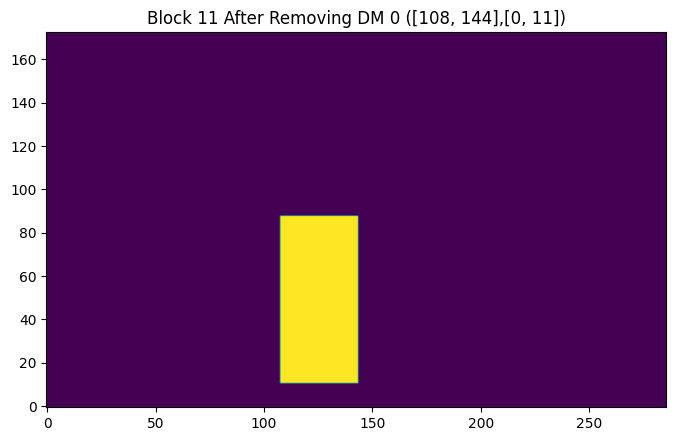

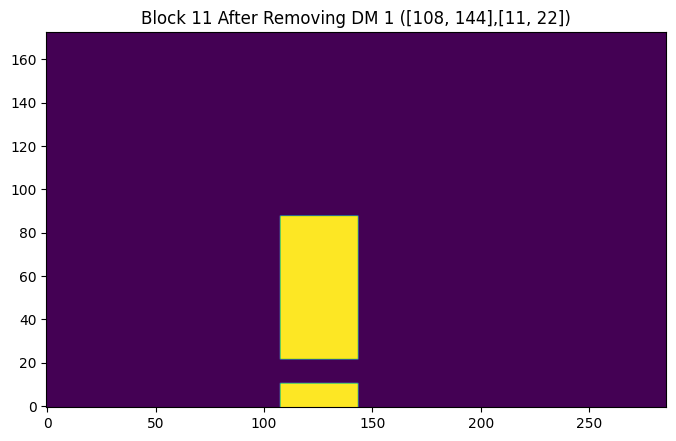

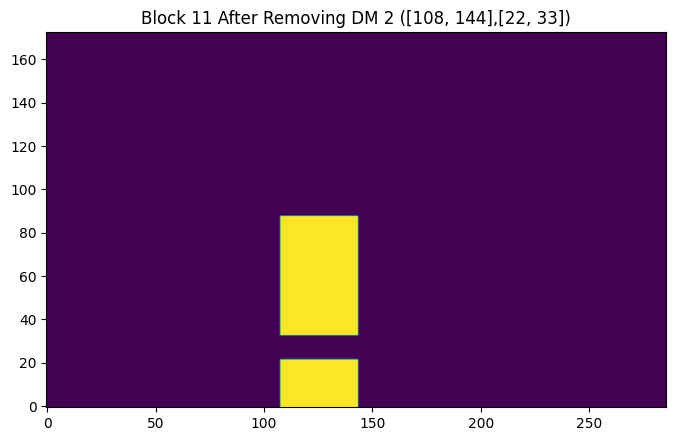

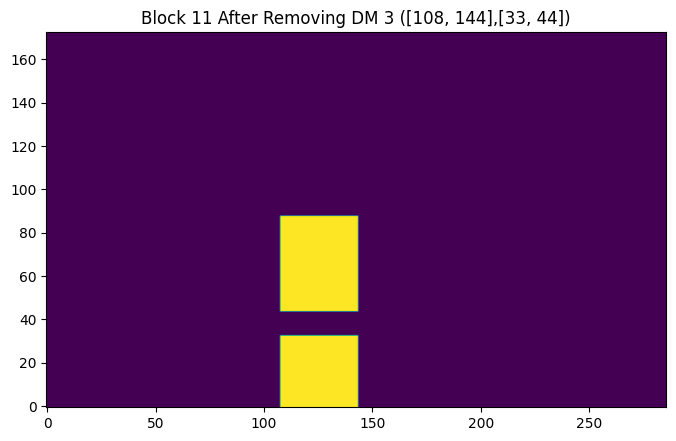

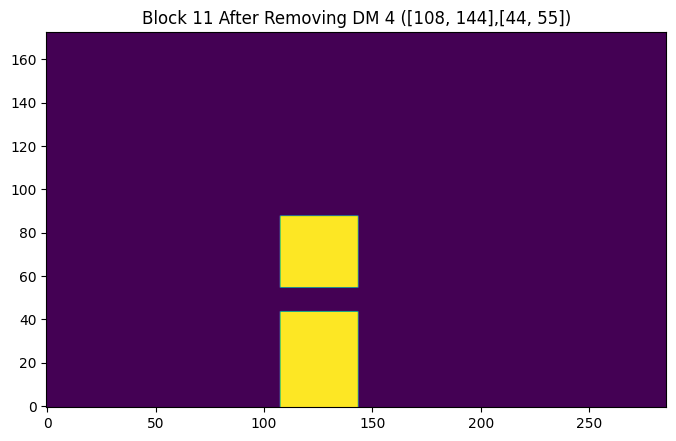

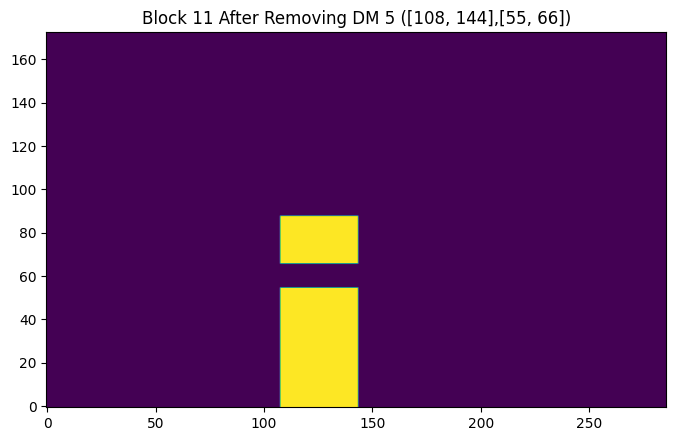

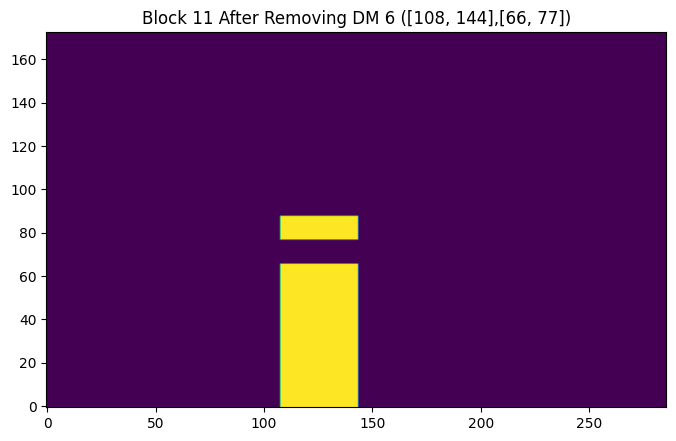

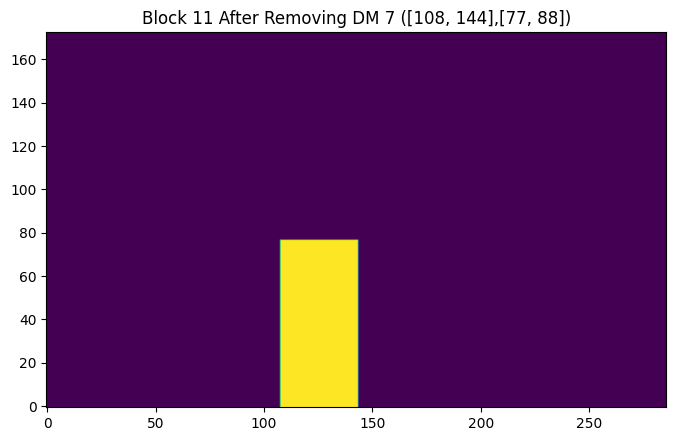

In [11]:
# Subdividing 11th Block into DMs (1/8th of block)
block_detxys[11]

DM_detxys = []
for i in range(8):

    DETX = block_detxys[11][0]
    DETY = [11*i, (i+1)*11]
            
    DM_detxys.append([DETX,DETY])

DM_detxys

# Setting up a new dmask that blocks all blocks except block 11.
block_coords = block_detxys[11]
dmask_block_11_only = np.full((173,286),1.)
dmask_block_11_only[block_coords[1][0]:block_coords[1][1], block_coords[0][0]:block_coords[0][1]] = 0.

# Blocking off individual DM
absolute_diffs_after_removing_DMs = []
j=0
for DM_coords in DM_detxys:

    block_DM_dmask = np.copy(dmask_block_11_only)
    block_DM_dmask[DM_coords[1][0]:DM_coords[1][1], DM_coords[0][0]:DM_coords[0][1]] = 1.
    new_bl_dmask = (block_DM_dmask==0.)
    fig = plt.figure(figsize=(8, 5))
    plt.imshow(new_bl_dmask)
    plt.title("Block 11 After Removing DM {a} ({b},{c})".format(a = j, b = DM_coords[0], c = DM_coords[1]))
    plt.gca().invert_yaxis()
    absolute_diff_dpis = []
    absolute_diff_dpis_bl_dmask = []
    average_of_absolute_diff_dpis = []
    variances_of_residuals = []
    total_count_data = 0.0
    total_count_model = 0.0
    j+=1
    for i in range(nebins):

        # dpis for visualizing absolute difference dpi 
        y1 = exp*data_ebin_dpis[i]
        y2 = exp*model_ebin_dpis[i]
        
        # dpis for calculating average and histogram of just the absolute differences
        # between the detectors coded by bl_dmask
        y1_bl_dmask = y1[new_bl_dmask]
        y2_bl_dmask = y2[new_bl_dmask]
        
        # Calculating absolute difference dpi using y1 and y2
        absolute_diff = y1 - y2

        # updating the total count difference between the data and model
        count_data = np.round(np.sum(y1_bl_dmask))
        count_model = np.round(np.sum(y2_bl_dmask))
        total_count_data += count_data
        total_count_model += count_model
        
        # Calculating absolutely difference dpi using y1_bl_dmask and y2_bl_dmask
        absolute_diff_bl_dmask = y1_bl_dmask - y2_bl_dmask
        variances_of_residuals.append(round(np.var(absolute_diff_bl_dmask), 2))
        average_of_absolute_diff_dpis.append(np.round(np.average(absolute_diff_bl_dmask),2))
        
        absolute_diff_dpis.append(absolute_diff)
        absolute_diff_dpis_bl_dmask.append(absolute_diff_bl_dmask)

    # Storing results into a dictionary to be stored into absolute_diffs_after_removing_blocks.
    results = {}
    results["DM_coords"] = DM_coords
    results["variances_of_residuals"] = variances_of_residuals
    results["total_count_data"] = total_count_data
    results["total_count_model"] = total_count_model
    results["average_of_absolute_diff_dpis"] = average_of_absolute_diff_dpis
    results["absolute_diff_dpis_bl_dmask"] = absolute_diff_dpis_bl_dmask
    absolute_diffs_after_removing_DMs.append(results)


In [12]:
full_block_11_avg_abs_diffs = np.zeros(nebins)
full_block_11_var = np.zeros(nebins)
bl_dmask_block_11_only = (dmask_block_11_only==0.)

for i in range(nebins):

        # dpis for visualizing absolute difference dpi 
        y1 = exp*data_ebin_dpis[i]
        y2 = exp*model_ebin_dpis[i]
        
        # dpis for calculating average and histogram of just the absolute differences
        # between the detectors coded by bl_dmask
        y1_bl_dmask = y1[bl_dmask_block_11_only]
        y2_bl_dmask = y2[bl_dmask_block_11_only]
        
        # Calculating absolutely difference dpi using y1_bl_dmask and y2_bl_dmask
        absolute_diff_bl_dmask = y1_bl_dmask - y2_bl_dmask
        
        full_block_11_avg_abs_diffs[i] = np.round(np.average(absolute_diff_bl_dmask), 2)
        full_block_11_var[i] = round(np.var(absolute_diff_bl_dmask), 2)


# Calculate the difference in the average absolute differences between the full detector plane and after removing DM i (0<= i <=7). Compile 
# it into list and display with matplotlib
def compare_avg_abs_diffs_by_DM_id(DM_id):
    
    # Need the absolute differences and variances for full detector plane
    change_in_diffs = np.round(full_block_11_avg_abs_diffs - absolute_diffs_after_removing_DMs[DM_id]["average_of_absolute_diff_dpis"],2)
    change_in_vars = np.round(full_block_11_var - absolute_diffs_after_removing_DMs[DM_id]["variances_of_residuals"],2)
    
    print("DM id ", DM_id)
    print("Change in Average Absolute Differences Compared to Full Block 11: ", change_in_diffs)
    print("Sum of Change in Average Absolute Differences: ", round(np.sum(change_in_diffs),2))

    print("Change in Variances Compared to Full Block 11: ", change_in_vars)
    print('\n')


for i in range(8):
        compare_avg_abs_diffs_by_DM_id(i)

DM id  0
Change in Average Absolute Differences Compared to Full Block 11:  [ 0.01  0.   -0.01  0.    0.    0.    0.    0.    0.  ]
Sum of Change in Average Absolute Differences:  0.0
Change in Variances Compared to Full Block 11:  [-0.21 -0.08 -0.02  0.   -0.01 -0.03 -0.01  0.    0.  ]


DM id  1
Change in Average Absolute Differences Compared to Full Block 11:  [-0.03  0.    0.    0.01  0.01  0.01 -0.02  0.    0.  ]
Sum of Change in Average Absolute Differences:  -0.02
Change in Variances Compared to Full Block 11:  [-0.06 -0.01 -0.01  0.    0.01  0.01  0.01  0.01  0.02]


DM id  2
Change in Average Absolute Differences Compared to Full Block 11:  [-0.01 -0.01  0.   -0.01 -0.01  0.    0.01  0.   -0.01]
Sum of Change in Average Absolute Differences:  -0.04
Change in Variances Compared to Full Block 11:  [-0.19 -0.09 -0.06 -0.05 -0.07 -0.05 -0.03 -0.04 -0.02]


DM id  3
Change in Average Absolute Differences Compared to Full Block 11:  [0.04 0.   0.   0.01 0.   0.02 0.01 0.   0.  ]
Sum